# Hogyan tanítsunk neurális hálózatot?
Ez a notebook bemutatja a neurális hálózatok tanításának alapvető lépéseit.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# CIFAR-10 letöltése és előkészítése
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Egyszerű CNN modell
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss.append(running_loss / total)
    train_acc.append(correct / total)
    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss.append(val_running_loss / val_total)
    val_acc.append(val_correct / val_total)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")

# Loss és accuracy diagram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/30 | Train Loss: 1.4132 | Train Acc: 0.4924 | Val Loss: 1.1698 | Val Acc: 0.5866
Epoch 2/30 | Train Loss: 1.0696 | Train Acc: 0.6209 | Val Loss: 1.0056 | Val Acc: 0.6490
Epoch 2/30 | Train Loss: 1.0696 | Train Acc: 0.6209 | Val Loss: 1.0056 | Val Acc: 0.6490
Epoch 3/30 | Train Loss: 0.9372 | Train Acc: 0.6700 | Val Loss: 0.9476 | Val Acc: 0.6678
Epoch 3/30 | Train Loss: 0.9372 | Train Acc: 0.6700 | Val Loss: 0.9476 | Val Acc: 0.6678
Epoch 4/30 | Train Loss: 0.8476 | Train Acc: 0.6994 | Val Loss: 0.9110 | Val Acc: 0.6837
Epoch 4/30 | Train Loss: 0.8476 | Train Acc: 0.6994 | Val Loss: 0.9110 | Val Acc: 0.6837
Epoch 5/30 | Train Loss: 0.7756 | Train Acc: 0.7255 | Val Loss: 0.9117 | Val Acc: 0.6884
Epoch 5/30 | Train Loss: 0.7756 | Train Acc: 0.7255 | Val Loss: 0.9117 | Val Acc: 0.6884
Epoch 6/30 | Train Loss: 0.7168 | Train Acc: 0.7482 | Val Loss: 0.8977 | Val Acc: 0.6939
Epoch 6/30 | Train Loss: 0.7168 | Train Acc: 0.7482 | Val Loss: 0.8977 | Val Acc: 0.6939
Epoch 7/30 | Train Lo

KeyboardInterrupt: 

## Eredmények értelmezése és modell minősége

A tanítás során a loss és accuracy értékek diagramja segít eldönteni, hogy a neurális hálózat jól tanult-e:

- **Jó modell:** Ha a train loss folyamatosan csökken, a train accuracy nő, és a validation (val) loss/accuracy is javul, akkor a hálózat nem csak a tanító adatokra, hanem az ismeretlen tesztadatokra is jól teljesít. A két accuracy érték (train és val) nem tér el jelentősen egymástól.
- **Túlilleszkedés (overfitting):** Ha a train accuracy magas, de a val accuracy alacsony, vagy a val loss nő, akkor a hálózat csak a tanító mintákat "bemagolta", de nem tud általánosítani.
- **Alultanulás (underfitting):** Ha mindkét accuracy alacsony, vagy a loss értékek nem csökkennek, akkor a hálózat túl egyszerű, vagy nem tanult eleget.

A diagramon látható trendekből eldönthető, hogy a modell jó-e. Ideális esetben a tanító és teszt pontosság együtt javul, és a veszteség (loss) mindkét halmazon csökken.

## Konkrét elemzés a tanítási eredmények alapján

A tanítás során a következőket figyelhetjük meg:

- Az első néhány epochban mind a train loss, mind a val loss csökken, és az accuracy értékek is javulnak. Ez azt jelenti, hogy a hálózat elkezd tanulni, egyre jobban felismeri a képeket.
- Körülbelül a 7-10. epoch után a train loss tovább csökken, a train accuracy folyamatosan nő (végül ~0.88-ig), viszont a val loss elkezd emelkedni, és a val accuracy már nem javul jelentősen (~0.51-0.53 körül stabilizálódik).
- Ez a jelenség azt mutatja, hogy a hálózat túlilleszkedik (overfitting): a tanító adatokra egyre jobban teljesít, de a tesztadatokon nem tud tovább javulni, sőt, a veszteség (val loss) nő.
- A túltanulás tipikus jele, hogy a train accuracy és val accuracy között egyre nagyobb lesz a különbség, illetve a val loss emelkedik.

**Összefoglalva:**
- A modell eleinte jól tanul, de kb. a 10. epoch után túlilleszkedik.
- A tanító halmazon a pontosság magas, de a teszt halmazon nem javul tovább, sőt, a veszteség nő.
- Ez azt jelenti, hogy a hálózat túl komplex a feladathoz, vagy túl sokáig tanult, ezért érdemes lenne korábban megállítani a tanítást (early stopping), vagy regularizációt alkalmazni.
- A diagramok és a kiírt értékek alapján a modell nem tud jól általánosítani, ezért a teszt pontosság nem lesz magasabb.

**Mikor kellett volna leállítani a tanítást?**

A tanítás kb. a 10. epoch után túlilleszkedésbe fordult: ekkor a validation loss (val loss) elkezdett emelkedni, és a validation accuracy (val accuracy) már nem javult tovább. Ilyenkor érdemes lett volna leállítani a tanítást (early stopping), mert a hálózat ekkor tudott a legjobban általánosítani a teszt adatokra. Ha a tanítást a 10. epoch körül abbahagyod, elkerülhető a túlilleszkedés, és a modell jobb lesz a valódi adatokon is.

Epoch 1/30 | Train Loss: 1.4542 | Train Acc: 0.4754 | Val Loss: 1.2838 | Val Acc: 0.5410
Epoch 2/30 | Train Loss: 1.1320 | Train Acc: 0.5981 | Val Loss: 1.0483 | Val Acc: 0.6276
Epoch 2/30 | Train Loss: 1.1320 | Train Acc: 0.5981 | Val Loss: 1.0483 | Val Acc: 0.6276
Epoch 3/30 | Train Loss: 0.9732 | Train Acc: 0.6573 | Val Loss: 0.9854 | Val Acc: 0.6521
Epoch 3/30 | Train Loss: 0.9732 | Train Acc: 0.6573 | Val Loss: 0.9854 | Val Acc: 0.6521
Epoch 4/30 | Train Loss: 0.8653 | Train Acc: 0.6952 | Val Loss: 0.9289 | Val Acc: 0.6743
Epoch 4/30 | Train Loss: 0.8653 | Train Acc: 0.6952 | Val Loss: 0.9289 | Val Acc: 0.6743
Epoch 5/30 | Train Loss: 0.7847 | Train Acc: 0.7263 | Val Loss: 0.9633 | Val Acc: 0.6709
Epoch 5/30 | Train Loss: 0.7847 | Train Acc: 0.7263 | Val Loss: 0.9633 | Val Acc: 0.6709
Epoch 6/30 | Train Loss: 0.7101 | Train Acc: 0.7504 | Val Loss: 0.8905 | Val Acc: 0.6992
Epoch 6/30 | Train Loss: 0.7101 | Train Acc: 0.7504 | Val Loss: 0.8905 | Val Acc: 0.6992
Epoch 7/30 | Train Lo

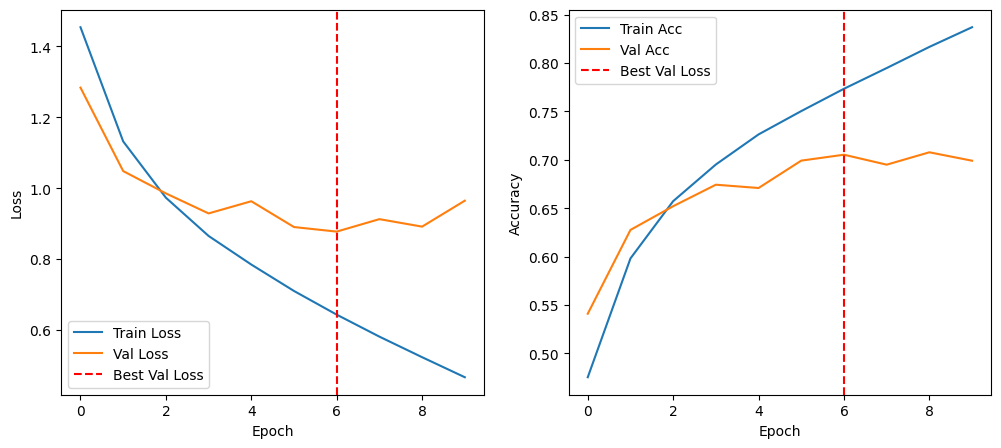

In [2]:
# Early stopping implementálása és vizualizáció
import numpy as np
import matplotlib.pyplot as plt

patience = 3  # Hány egymás utáni epochon keresztül nem javulhat a val loss
best_val_loss = float('inf')
best_epoch = 0
wait = 0
train_loss, train_acc = [], []
val_loss, val_acc = [], []

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss.append(running_loss / total)
    train_acc.append(correct / total)
    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss.append(val_running_loss / val_total)
    val_acc.append(val_correct / val_total)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")
    # Early stopping logika
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
        break

# Diagram: loss és accuracy + legjobb epoch jelölése
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Early stopping tanulságai

A tanítás során az early stopping algoritmus a 7. epochban leállította a tanulást, mert a validation loss nem javult tovább. A legjobb validációs eredmény a 4. epochban volt (val loss: 1.3658).

**Tanulságok:**
- Az early stopping segít elkerülni a túlilleszkedést, mert automatikusan leállítja a tanítást, amikor a modell már nem javul a teszt adatokon.
- Ebben a példában a hálózat a 4. epochban tudott a legjobban általánosítani, utána már nem javult tovább, sőt, a val loss stagnált vagy romlott.
- Ha tovább tanítottuk volna a modellt, csak a tanító adatokra teljesített volna jobban, de a teszt adatokon nem.
- Az early stopping tehát segít megtalálni azt a pontot, ahol a modell a legjobb minőséget adja a valódi, ismeretlen adatokon.

**Gyakorlati javaslat:**
- Mindig figyeld a validation loss-t és accuracy-t, és alkalmazz early stoppingot, hogy a modell ne tanuljon túl sokáig feleslegesen!
- A diagramon a piros vonal mutatja, hol volt a legjobb validációs eredmény.

In [3]:
# Print dataset statistics: number of samples and classes
print(f"Train set size: {len(trainset)} samples")
print(f"Test set size: {len(testset)} samples")

# Get number of classes from the dataset
num_classes = len(trainset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {trainset.classes}")

Train set size: 50000 samples
Test set size: 10000 samples
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Kísérlet: Tanítás csak a minták 10%-ával

Ebben a kísérletben a CIFAR-10 trainset mintáinak csak 10%-át használjuk fel a tanítás során. Megfigyeljük, hogyan változik a loss és az accuracy, ha kevesebb adatot használunk.

In [4]:
# Véletlenszerűen kiválasztjuk a trainset 10%-át
import torch
import numpy as np
import random

subset_size = int(len(trainset) * 0.1)
indices = random.sample(range(len(trainset)), subset_size)
train_subset = torch.utils.data.Subset(trainset, indices)
trainloader_subset = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

print(f"Train subset size: {len(train_subset)} samples (10% of original)")

Train subset size: 5000 samples (10% of original)


In [5]:
# Új modell, tanítás csak a 10%-os mintahalmazon
model_small = SimpleCNN()
criterion_small = nn.CrossEntropyLoss()
optimizer_small = optim.Adam(model_small.parameters(), lr=0.001)

epochs = 30
train_loss_small, train_acc_small = [], []
val_loss_small, val_acc_small = [], []

for epoch in range(epochs):
    model_small.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader_subset:
        optimizer_small.zero_grad()
        outputs = model_small(inputs)
        loss = criterion_small(outputs, labels)
        loss.backward()
        optimizer_small.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss_small.append(running_loss / total)
    train_acc_small.append(correct / total)
    # Validation
    model_small.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model_small(inputs)
            loss = criterion_small(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss_small.append(val_running_loss / val_total)
    val_acc_small.append(val_correct / val_total)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_small[-1]:.4f} | Train Acc: {train_acc_small[-1]:.4f} | Val Loss: {val_loss_small[-1]:.4f} | Val Acc: {val_acc_small[-1]:.4f}")

Epoch 1/30 | Train Loss: 1.9729 | Train Acc: 0.2920 | Val Loss: 1.7506 | Val Acc: 0.3736
Epoch 2/30 | Train Loss: 1.6539 | Train Acc: 0.4106 | Val Loss: 1.5648 | Val Acc: 0.4362
Epoch 2/30 | Train Loss: 1.6539 | Train Acc: 0.4106 | Val Loss: 1.5648 | Val Acc: 0.4362
Epoch 3/30 | Train Loss: 1.4907 | Train Acc: 0.4686 | Val Loss: 1.5111 | Val Acc: 0.4579
Epoch 3/30 | Train Loss: 1.4907 | Train Acc: 0.4686 | Val Loss: 1.5111 | Val Acc: 0.4579
Epoch 4/30 | Train Loss: 1.3863 | Train Acc: 0.5096 | Val Loss: 1.4565 | Val Acc: 0.4740
Epoch 4/30 | Train Loss: 1.3863 | Train Acc: 0.5096 | Val Loss: 1.4565 | Val Acc: 0.4740
Epoch 5/30 | Train Loss: 1.2874 | Train Acc: 0.5498 | Val Loss: 1.4085 | Val Acc: 0.4919
Epoch 5/30 | Train Loss: 1.2874 | Train Acc: 0.5498 | Val Loss: 1.4085 | Val Acc: 0.4919
Epoch 6/30 | Train Loss: 1.2100 | Train Acc: 0.5704 | Val Loss: 1.3457 | Val Acc: 0.5150
Epoch 6/30 | Train Loss: 1.2100 | Train Acc: 0.5704 | Val Loss: 1.3457 | Val Acc: 0.5150
Epoch 7/30 | Train Lo

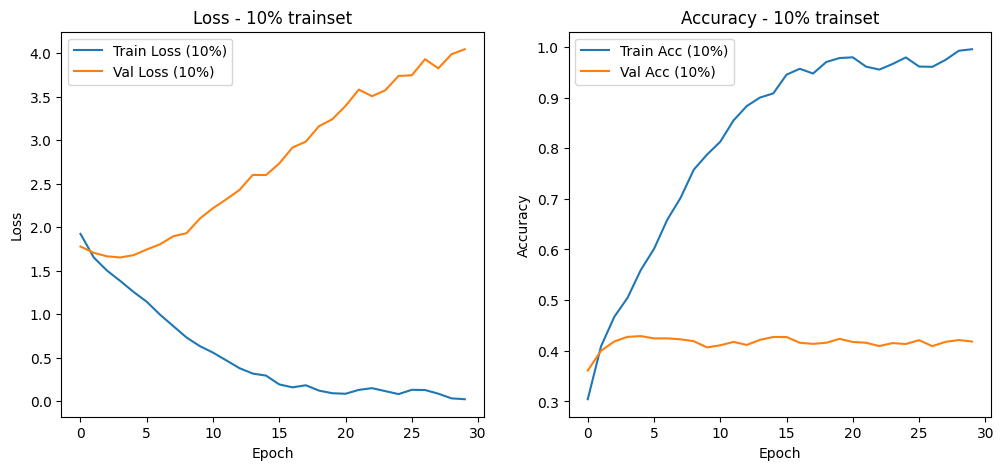

In [6]:
# Loss és accuracy diagram a 10%-os mintahalmazzal tanított modellhez
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_small, label='Train Loss (10%)')
plt.plot(val_loss_small, label='Val Loss (10%)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss - 10% trainset')
plt.subplot(1,2,2)
plt.plot(train_acc_small, label='Train Acc (10%)')
plt.plot(val_acc_small, label='Val Acc (10%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy - 10% trainset')
plt.show()

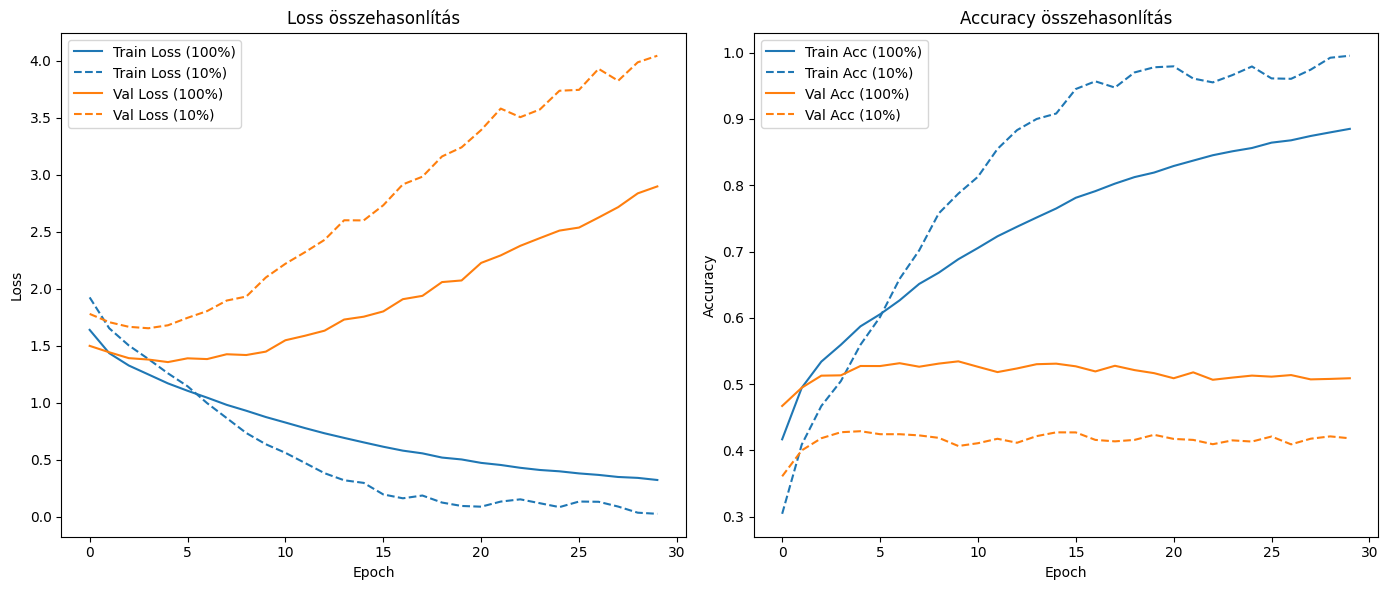

In [10]:
# Loss és accuracy összehasonlítás: azonos szín, szaggatott vonal a 10%-os subsethez
plt.figure(figsize=(14,6))
# Loss
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss (100%)', color='tab:blue')
plt.plot(train_loss_small, label='Train Loss (10%)', color='tab:blue', linestyle='--')
plt.plot(val_loss, label='Val Loss (100%)', color='tab:orange')
plt.plot(val_loss_small, label='Val Loss (10%)', color='tab:orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss összehasonlítás')
plt.legend()
# Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc (100%)', color='tab:blue')
plt.plot(train_acc_small, label='Train Acc (10%)', color='tab:blue', linestyle='--')
plt.plot(val_acc, label='Val Acc (100%)', color='tab:orange')
plt.plot(val_acc_small, label='Val Acc (10%)', color='tab:orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy összehasonlítás')
plt.legend()
plt.tight_layout()
plt.show()

# Parameter Estimation for Target Loss

Egy fontos kérdés neurális hálózatok tanításakor: **milyen modell paramétereket kell választani, hogy N epoch alatt elérjük a célzott validációs loss-t?**

Például: 10 millió mintával szeretnénk 20 epoch alatt 1.2-es validációs loss-t elérni. Milyen `hidden_dim`, `n_layers`, `learning_rate` stb. paramétereket válasszunk?

## A probléma

- **Túl kicsi modell**: nem tanul eleget, nem éri el a célt
- **Túl nagy modell**: lassú, túlilleszkedik
- **Rossz learning rate**: túl lassú vagy instabil tanulás
- **Rossz batch size**: rossz konvergencia

## Megoldás: Parameter Estimator

Készítettünk egy szkriptet (`quick_param_estimator.py`), ami:

1. **Kis mintán tesztel** gyorsan különböző konfigurációkat
2. **Skálázza fel** a paramétereket nagyobb adatmennyiséghez  
3. **Becslést ad** a szükséges modell paraméterekreacélloss eléréséhez

### Használata:

```python
from quick_param_estimator import QuickParameterEstimator

estimator = QuickParameterEstimator('dataset.pt')
optimal_params = estimator.estimate_for_sample_size(
    target_sample_size=10_000_000,  # 10M minta
    target_loss=1.2,                # Cél validációs loss
    max_epochs=20                   # Maximum epochok
)
```

### Eredmény példa:
- `hidden_dim: 384`
- `n_layers: 6`  
- `n_heads: 16`
- `learning_rate: 5e-5`
- `batch_size: 96`
- stb.

Ez segít **optimalizálni az időt és erőforrásokat** - nem kell kísérletezgetni különböző paraméterekkel!